# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

<ipython-input-1-1499ab5789c7>:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle
import random
from random import sample

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

#from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler
from pytorch_model import Conditional_VAE as Model
#from pytorch_utils import filtered_load_model
#import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
log_file = config['IO_OPTION']['OUTPUT_ROOT']+'/train_{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_file, '00_train.py')

## Setting

In [5]:
# Setting seed
modeler.set_seed(777)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
#dev_dir = INPUT_ROOT + "/dev_data"
#add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = ['ToyCar', 'gearbox', 'valve', 'ToyTrain', 'pump', 'fan', 'slider']
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
OUT_SCORE_DIR = OUTPUT_ROOT + '/score'
OUT_PRED_DIR = OUTPUT_ROOT + '/pred'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
os.makedirs(OUT_SCORE_DIR, exist_ok=True)
os.makedirs(OUT_PRED_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/dcase2021_task2/output/CenterLossVAE/ex22/config.yaml'

In [7]:
torch.cuda.is_available()

True

In [8]:
ext_data = pd.read_pickle(f'{INPUT_ROOT}/valve_features.pkl')

In [9]:
#train_features = ext_data['train']['features']

In [10]:
#train_features.shape

## training

In [11]:
def random_feature_selection(x, t_d=3776, d=2048):
    idx = torch.tensor(sample(range(0, t_d), d)) # t_d(特徴量)の中からランダムにd個サンプリングする(ぜんぶやると重いから) # わからん
    # 0~t_d idxの中からランダムにd個サンプリングする
    x = np.take(x, idx, 1)
    return x

In [12]:
#ext_data['train'].keys()

In [13]:
#############################################################################
# run
#############################################################################
def run(machine_type):
    com.tic()
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dataloader
    #for machine in machine_types:
    #    if machine_type == machine:
    #        ext_data = pd.read_pickle(f'{INPUT_ROOT}/{machine}_features.pkl')
    #    else:
    #        ext_data_ = pd.read_pickle(f'{INPUT_ROOT}/{machine}_features.pkl')
    #        ext_data['train']['features'] = np.concatenate([ext_data['train']['features'],
    #                                                        ext_data_['train']['features']], axis=0)
    #        ext_data['train']['labels'] = np.concatenate([ext_data['train']['labels'],
    #                                                     ext_data_['train']['labels']], axis=0)
    #        ext_data['train']['wav_names'] = np.concatenate([ext_data['train']['wav_names'],
    #                                                         ext_data_['train']['wav_names']], axis=0)
            
    #t_d = 3776    # 全特徴量数
    #d = 1024      # 使う特徴量数
    #for phase in ['train', 'valid_source', 'valid_target']:
    #    x = ext_data[phase]['features']
    #    x = random_feature_selection(x)
    #    ext_data[phase]['features'] = x
    #    x = ext_data[phase]['features'][:,512:2048]
    #    ext_data[phase]['features'] = x
    dataloaders_dict = modeler.make_dataloader(ext_data)
    # define writer for tensorbord
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    # out path
    model_out_path = MODEL_DIR+'/{}_model.pth'.format(machine_type)
    score_out_path = OUT_SCORE_DIR + '/{}_score.csv'.format(machine_type)
    pred_out_path = OUT_PRED_DIR + '/{}_pred.csv'.format(machine_type)
    logger.info('TRAINING')
    # parameter setting
    in_features = ext_data['train']['features'].shape[1]
    mid_size = config['param']['mid_size']
    latent_size = config['param']['latent_size']
    num_classes = 6
    net = Model(in_features, mid_size, latent_size, num_classes)
    optimizer = optim.Adam(net.parameters(), lr=1e-4)
    num_epochs = config['param']['num_epochs']
    #scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e-2, 
    #                                          max_lr=1e-3, epochs=num_epochs, steps_per_epoch=len(dataloaders_dict['train']))
    # training
    output_dicts = modeler.train_net(net, dataloaders_dict, optimizer, num_epochs, writer, model_out_path, score_out_path, pred_out_path)
    
    com.toc()

In [14]:
machine_types

['ToyCar', 'gearbox', 'valve', 'ToyTrain', 'pump', 'fan', 'slider']

In [15]:
#for machine_type in machine_types:
#    run(machine_type)

2021-06-01 21:49:12,206 - 00_train.py - INFO - TARGET MACHINE_TYPE: valve
2021-06-01 21:49:12,207 - 00_train.py - INFO - MAKE DATA_LOADER
2021-06-01 21:49:13,099 - 00_train.py - INFO - TRAINING
2021-06-01 21:49:16,485 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 21.71it/s]
2021-06-01 21:49:17,041 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 109.14it/s]
2021-06-01 21:49:17,081 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 106.03it/s]


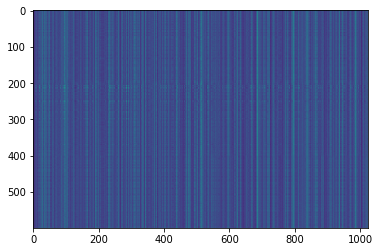

,AUC,pAUC
Source_0,0.508800,0.535789
Source_1,0.579400,0.523684
Source_2,0.566000,0.520526
Target_0,0.483800,0.525263
Target_1,0.677200,0.608947
Target_2,0.491000,0.493684
mean,0.551033,0.534649
h_mean,0.543556,0.532450


2021-06-01 21:49:18,530 - pytorch_modeler.py - INFO - epoch:1/300, train_losses:135.033809, val_AUC_hmean:0.543556, val_pAUC_hmean:0.532450, best_flag:True
2021-06-01 21:49:18,530 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 79.99it/s]
2021-06-01 21:49:18,683 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 141.56it/s]
2021-06-01 21:49:18,715 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 145.33it/s]


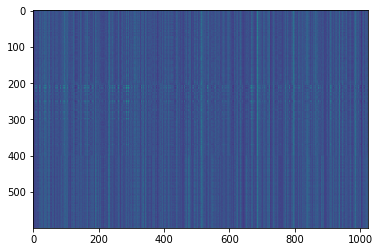

,AUC,pAUC
Source_0,0.525500,0.537895
Source_1,0.568900,0.534737
Source_2,0.628250,0.547895
Target_0,0.473800,0.531579
Target_1,0.701700,0.602632
Target_2,0.565300,0.493684
mean,0.577242,0.541404
h_mean,0.568336,0.539544


2021-06-01 21:49:20,231 - pytorch_modeler.py - INFO - epoch:2/300, train_losses:103.289991, val_AUC_hmean:0.568336, val_pAUC_hmean:0.539544, best_flag:True
2021-06-01 21:49:20,232 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 77.66it/s]
2021-06-01 21:49:20,388 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 125.44it/s]
2021-06-01 21:49:20,424 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 152.82it/s]


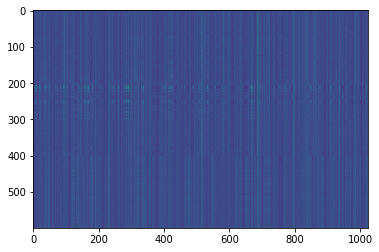

,AUC,pAUC
Source_0,0.535400,0.543158
Source_1,0.581100,0.537368
Source_2,0.649400,0.554211
Target_0,0.493300,0.566316
Target_1,0.715300,0.593684
Target_2,0.613000,0.492632
mean,0.597917,0.547895
h_mean,0.589100,0.546126


2021-06-01 21:49:21,954 - pytorch_modeler.py - INFO - epoch:3/300, train_losses:85.279235, val_AUC_hmean:0.589100, val_pAUC_hmean:0.546126, best_flag:True
2021-06-01 21:49:21,955 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 46.90it/s]
2021-06-01 21:49:22,213 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 132.81it/s]
2021-06-01 21:49:22,246 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 143.23it/s]


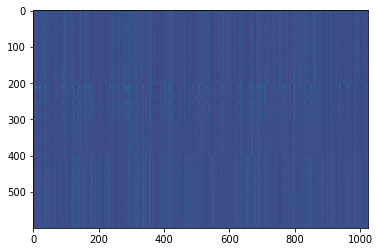

,AUC,pAUC
Source_0,0.546800,0.551579
Source_1,0.587600,0.544211
Source_2,0.666400,0.552632
Target_0,0.513800,0.584737
Target_1,0.725500,0.594211
Target_2,0.639600,0.497368
mean,0.613283,0.554123
h_mean,0.604877,0.552299


2021-06-01 21:49:23,757 - pytorch_modeler.py - INFO - epoch:4/300, train_losses:74.175541, val_AUC_hmean:0.604877, val_pAUC_hmean:0.552299, best_flag:True
2021-06-01 21:49:23,758 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 76.91it/s]
2021-06-01 21:49:23,916 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 151.09it/s]
2021-06-01 21:49:23,947 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 142.49it/s]


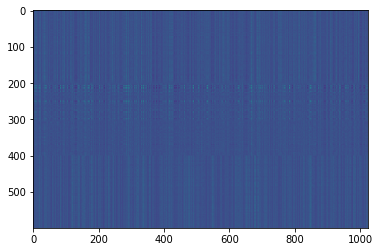

,AUC,pAUC
Source_0,0.560900,0.562105
Source_1,0.615900,0.554211
Source_2,0.706400,0.561579
Target_0,0.515000,0.598421
Target_1,0.728900,0.587368
Target_2,0.652200,0.503158
mean,0.629883,0.561140
h_mean,0.620536,0.559435


2021-06-01 21:49:25,438 - pytorch_modeler.py - INFO - epoch:5/300, train_losses:66.898100, val_AUC_hmean:0.620536, val_pAUC_hmean:0.559435, best_flag:True
2021-06-01 21:49:25,439 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 74.79it/s]
2021-06-01 21:49:25,601 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 122.10it/s]
2021-06-01 21:49:25,637 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 145.58it/s]
2021-06-01 21:49:25,675 - pytorch_modeler.py - INFO - epoch:6/300, train_losses:62.139390, val_AUC_hmean:0.616051, val_pAUC_hmean:0.557560, best_flag:False
2021-06-01 21:49:25,676 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 73.53it/s]
2021-06-01 21:49:25,841 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 101.70it/s]
2021-06-01 21:49:25,884 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 114.77it/s]


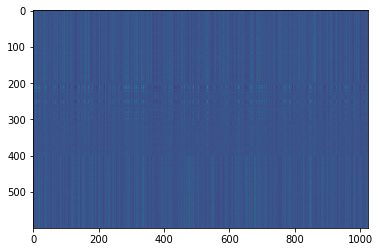

,AUC,pAUC
Source_0,0.581700,0.566316
Source_1,0.615800,0.559474
Source_2,0.799000,0.635789
Target_0,0.488000,0.604737
Target_1,0.709700,0.577368
Target_2,0.614300,0.510526
mean,0.634750,0.575702
h_mean,0.619792,0.573043


2021-06-01 21:49:27,372 - pytorch_modeler.py - INFO - epoch:7/300, train_losses:59.067875, val_AUC_hmean:0.619792, val_pAUC_hmean:0.573043, best_flag:True
2021-06-01 21:49:27,373 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 73.25it/s]
2021-06-01 21:49:27,539 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 133.31it/s]
2021-06-01 21:49:27,573 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 119.32it/s]


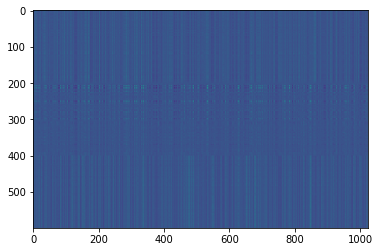

,AUC,pAUC
Source_0,0.600100,0.564737
Source_1,0.640800,0.585263
Source_2,0.828600,0.685789
Target_0,0.500600,0.597895
Target_1,0.705400,0.570000
Target_2,0.581700,0.517895
mean,0.642867,0.586930
h_mean,0.627082,0.582787


2021-06-01 21:49:29,032 - pytorch_modeler.py - INFO - epoch:8/300, train_losses:56.744797, val_AUC_hmean:0.627082, val_pAUC_hmean:0.582787, best_flag:True
2021-06-01 21:49:29,033 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 74.73it/s]
2021-06-01 21:49:29,195 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 140.15it/s]
2021-06-01 21:49:29,228 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 134.64it/s]


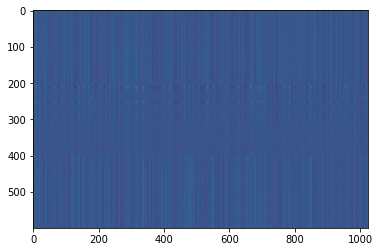

,AUC,pAUC
Source_0,0.586300,0.573684
Source_1,0.650400,0.577895
Source_2,0.818400,0.684211
Target_0,0.494300,0.614737
Target_1,0.706400,0.575789
Target_2,0.592200,0.506842
mean,0.641333,0.588860
h_mean,0.625500,0.584139


2021-06-01 21:49:30,771 - pytorch_modeler.py - INFO - epoch:9/300, train_losses:54.950464, val_AUC_hmean:0.625500, val_pAUC_hmean:0.584139, best_flag:True
2021-06-01 21:49:30,772 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 77.06it/s]
2021-06-01 21:49:30,929 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 146.00it/s]
2021-06-01 21:49:30,963 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 138.71it/s]


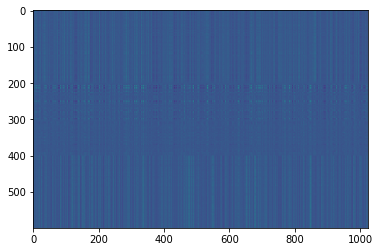

,AUC,pAUC
Source_0,0.596500,0.571579
Source_1,0.647100,0.580000
Source_2,0.831800,0.694211
Target_0,0.502400,0.610000
Target_1,0.700300,0.577368
Target_2,0.575900,0.516316
mean,0.642333,0.591579
h_mean,0.626381,0.586952


2021-06-01 21:49:32,470 - pytorch_modeler.py - INFO - epoch:10/300, train_losses:53.450641, val_AUC_hmean:0.626381, val_pAUC_hmean:0.586952, best_flag:True
2021-06-01 21:49:32,471 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 72.30it/s]
2021-06-01 21:49:32,639 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 157.87it/s]
2021-06-01 21:49:32,675 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 166.15it/s]
2021-06-01 21:49:32,711 - pytorch_modeler.py - INFO - epoch:11/300, train_losses:52.270835, val_AUC_hmean:0.625937, val_pAUC_hmean:0.583974, best_flag:False
2021-06-01 21:49:32,712 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 79.54it/s]
2021-06-01 21:49:32,865 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 138.54it/s]
2021-06-01 21:49:32,903 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 147.31it/s]
2021-06-01 21:4

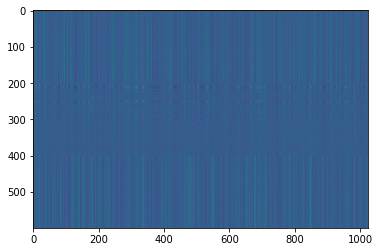

,AUC,pAUC
Source_0,0.605700,0.578947
Source_1,0.681400,0.600526
Source_2,0.831500,0.690000
Target_0,0.516400,0.620000
Target_1,0.698400,0.584737
Target_2,0.548800,0.504737
mean,0.647033,0.596491
h_mean,0.630803,0.591363


2021-06-01 21:49:34,770 - pytorch_modeler.py - INFO - epoch:13/300, train_losses:50.295646, val_AUC_hmean:0.630803, val_pAUC_hmean:0.591363, best_flag:True
2021-06-01 21:49:34,771 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 74.04it/s]
2021-06-01 21:49:34,935 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 153.46it/s]
2021-06-01 21:49:34,969 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 150.25it/s]


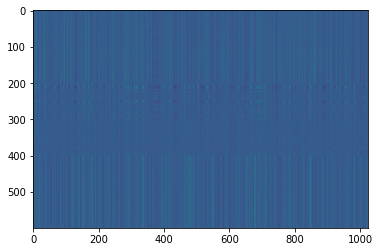

,AUC,pAUC
Source_0,0.611100,0.590000
Source_1,0.662000,0.581579
Source_2,0.828300,0.716842
Target_0,0.515200,0.622632
Target_1,0.700200,0.595789
Target_2,0.535100,0.506842
mean,0.641983,0.602281
h_mean,0.625507,0.596012


2021-06-01 21:49:36,488 - pytorch_modeler.py - INFO - epoch:14/300, train_losses:49.518341, val_AUC_hmean:0.625507, val_pAUC_hmean:0.596012, best_flag:True
2021-06-01 21:49:36,488 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 79.26it/s]
2021-06-01 21:49:36,642 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 137.59it/s]
2021-06-01 21:49:36,677 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 150.78it/s]
2021-06-01 21:49:36,717 - pytorch_modeler.py - INFO - epoch:15/300, train_losses:48.861761, val_AUC_hmean:0.640835, val_pAUC_hmean:0.595760, best_flag:False
2021-06-01 21:49:36,718 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 70.92it/s]
2021-06-01 21:49:36,889 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 146.78it/s]
2021-06-01 21:49:36,925 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 165.87it/s]


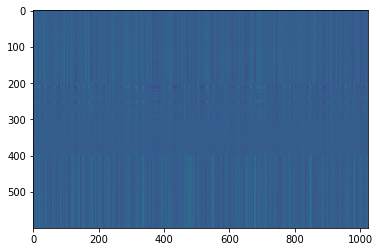

,AUC,pAUC
Source_0,0.615700,0.590000
Source_1,0.693000,0.598947
Source_2,0.832700,0.698421
Target_0,0.533400,0.621053
Target_1,0.706000,0.597895
Target_2,0.562700,0.520526
mean,0.657250,0.604474
h_mean,0.642644,0.599991


2021-06-01 21:49:38,492 - pytorch_modeler.py - INFO - epoch:16/300, train_losses:48.331123, val_AUC_hmean:0.642644, val_pAUC_hmean:0.599991, best_flag:True
2021-06-01 21:49:38,493 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 79.83it/s]
2021-06-01 21:49:38,646 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 142.97it/s]
2021-06-01 21:49:38,678 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 151.12it/s]


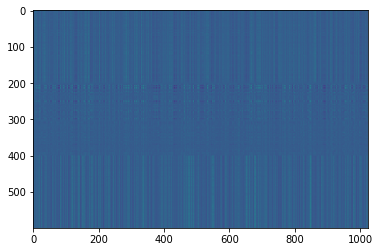

,AUC,pAUC
Source_0,0.644400,0.592632
Source_1,0.705600,0.594211
Source_2,0.833900,0.713684
Target_0,0.558900,0.623684
Target_1,0.707000,0.600526
Target_2,0.536200,0.517368
mean,0.664333,0.607018
h_mean,0.649570,0.601630


2021-06-01 21:49:40,204 - pytorch_modeler.py - INFO - epoch:17/300, train_losses:47.567724, val_AUC_hmean:0.649570, val_pAUC_hmean:0.601630, best_flag:True
2021-06-01 21:49:40,206 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 71.47it/s]
2021-06-01 21:49:40,376 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 124.08it/s]
2021-06-01 21:49:40,415 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 142.80it/s]


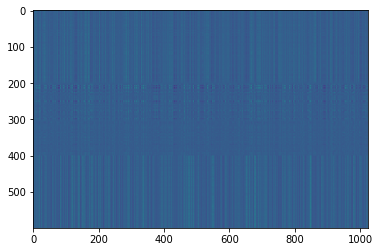

,AUC,pAUC
Source_0,0.636100,0.601579
Source_1,0.711200,0.596316
Source_2,0.810300,0.711579
Target_0,0.564200,0.631579
Target_1,0.711200,0.609474
Target_2,0.525100,0.498947
mean,0.659683,0.608246
h_mean,0.645497,0.601631


2021-06-01 21:49:41,894 - pytorch_modeler.py - INFO - epoch:18/300, train_losses:46.797440, val_AUC_hmean:0.645497, val_pAUC_hmean:0.601631, best_flag:True
2021-06-01 21:49:41,895 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 79.24it/s]
2021-06-01 21:49:42,049 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 136.38it/s]
2021-06-01 21:49:42,082 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 121.74it/s]
2021-06-01 21:49:42,122 - pytorch_modeler.py - INFO - epoch:19/300, train_losses:46.335415, val_AUC_hmean:0.643100, val_pAUC_hmean:0.599172, best_flag:False
2021-06-01 21:49:42,123 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 77.76it/s]
2021-06-01 21:49:42,280 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 129.59it/s]
2021-06-01 21:49:42,317 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 144.34it/s]
2021-06-01 21:4

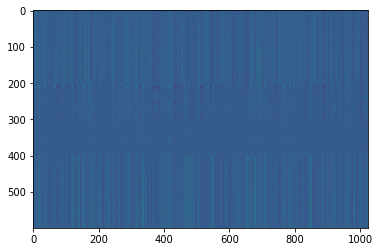

,AUC,pAUC
Source_0,0.647400,0.607368
Source_1,0.700100,0.588947
Source_2,0.845700,0.707368
Target_0,0.562900,0.631053
Target_1,0.707700,0.623684
Target_2,0.551200,0.508421
mean,0.669167,0.611140
h_mean,0.655077,0.605267


2021-06-01 21:49:44,634 - pytorch_modeler.py - INFO - epoch:23/300, train_losses:44.220293, val_AUC_hmean:0.655077, val_pAUC_hmean:0.605267, best_flag:True
2021-06-01 21:49:44,635 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 73.36it/s]
2021-06-01 21:49:44,801 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 135.35it/s]
2021-06-01 21:49:44,835 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 142.09it/s]
2021-06-01 21:49:44,874 - pytorch_modeler.py - INFO - epoch:24/300, train_losses:43.765274, val_AUC_hmean:0.649139, val_pAUC_hmean:0.599732, best_flag:False
2021-06-01 21:49:44,875 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 72.50it/s]
2021-06-01 21:49:45,042 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 136.13it/s]
2021-06-01 21:49:45,077 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 131.99it/s]


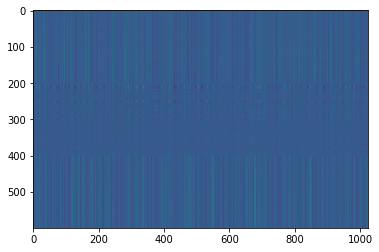

,AUC,pAUC
Source_0,0.657500,0.608947
Source_1,0.701800,0.597368
Source_2,0.853200,0.706842
Target_0,0.565000,0.632632
Target_1,0.712700,0.624737
Target_2,0.520100,0.502105
mean,0.668383,0.612105
h_mean,0.651210,0.605821


2021-06-01 21:49:46,608 - pytorch_modeler.py - INFO - epoch:25/300, train_losses:43.337374, val_AUC_hmean:0.651210, val_pAUC_hmean:0.605821, best_flag:True
2021-06-01 21:49:46,609 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 73.35it/s]
2021-06-01 21:49:46,775 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 123.75it/s]
2021-06-01 21:49:46,810 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 158.21it/s]


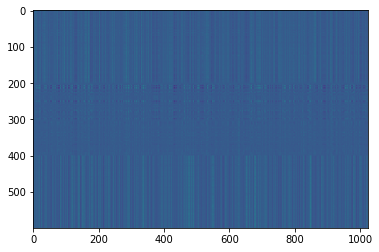

,AUC,pAUC
Source_0,0.637300,0.609474
Source_1,0.712100,0.608947
Source_2,0.855400,0.720526
Target_0,0.546500,0.627895
Target_1,0.722600,0.623158
Target_2,0.585900,0.506842
mean,0.676633,0.616140
h_mean,0.662036,0.609684


2021-06-01 21:49:48,329 - pytorch_modeler.py - INFO - epoch:26/300, train_losses:42.765123, val_AUC_hmean:0.662036, val_pAUC_hmean:0.609684, best_flag:True
2021-06-01 21:49:48,330 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 76.11it/s]
2021-06-01 21:49:48,490 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 136.21it/s]
2021-06-01 21:49:48,525 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 120.90it/s]


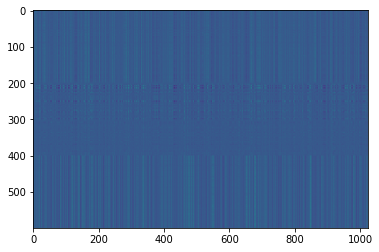

,AUC,pAUC
Source_0,0.661500,0.618421
Source_1,0.729600,0.625263
Source_2,0.824200,0.710526
Target_0,0.588200,0.638421
Target_1,0.735500,0.646842
Target_2,0.542100,0.507895
mean,0.680183,0.624561
h_mean,0.666665,0.618238


2021-06-01 21:49:50,063 - pytorch_modeler.py - INFO - epoch:27/300, train_losses:42.464359, val_AUC_hmean:0.666665, val_pAUC_hmean:0.618238, best_flag:True
2021-06-01 21:49:50,063 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 77.16it/s]
2021-06-01 21:49:50,221 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 119.43it/s]
2021-06-01 21:49:50,257 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 151.12it/s]
2021-06-01 21:49:50,292 - pytorch_modeler.py - INFO - epoch:28/300, train_losses:41.909475, val_AUC_hmean:0.671589, val_pAUC_hmean:0.610499, best_flag:False
2021-06-01 21:49:50,293 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 75.90it/s]
2021-06-01 21:49:50,453 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 151.78it/s]
2021-06-01 21:49:50,487 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 149.19it/s]
2021-06-01 21:4

100%|██████████| 2/2 [00:00<00:00, 105.27it/s]
2021-06-01 21:49:54,275 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 124.00it/s]


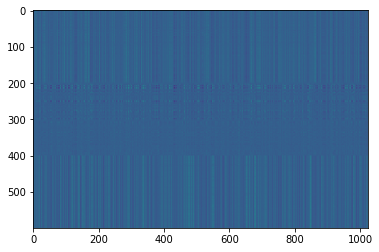

,AUC,pAUC
Source_0,0.688200,0.629474
Source_1,0.734600,0.628421
Source_2,0.857200,0.710000
Target_0,0.606900,0.640000
Target_1,0.751600,0.663684
Target_2,0.589400,0.505263
mean,0.704650,0.629474
h_mean,0.693177,0.622615


2021-06-01 21:49:55,800 - pytorch_modeler.py - INFO - epoch:44/300, train_losses:36.520217, val_AUC_hmean:0.693177, val_pAUC_hmean:0.622615, best_flag:True
2021-06-01 21:49:55,800 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 76.62it/s]
2021-06-01 21:49:55,959 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 118.34it/s]
2021-06-01 21:49:55,996 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 140.49it/s]


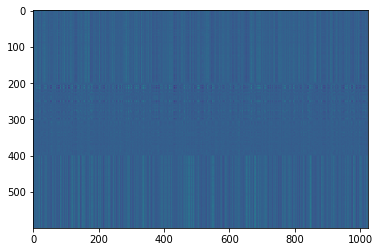

,AUC,pAUC
Source_0,0.698500,0.634211
Source_1,0.729200,0.621053
Source_2,0.861600,0.735263
Target_0,0.612000,0.636316
Target_1,0.744900,0.660000
Target_2,0.607800,0.512105
mean,0.709000,0.633158
h_mean,0.698864,0.625886


2021-06-01 21:49:57,611 - pytorch_modeler.py - INFO - epoch:45/300, train_losses:36.184757, val_AUC_hmean:0.698864, val_pAUC_hmean:0.625886, best_flag:True
2021-06-01 21:49:57,612 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 75.88it/s]
2021-06-01 21:49:57,772 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 122.23it/s]
2021-06-01 21:49:57,809 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 142.33it/s]
2021-06-01 21:49:57,848 - pytorch_modeler.py - INFO - epoch:46/300, train_losses:35.969230, val_AUC_hmean:0.694791, val_pAUC_hmean:0.624198, best_flag:False
2021-06-01 21:49:57,849 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 77.15it/s]
2021-06-01 21:49:58,006 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 115.95it/s]
2021-06-01 21:49:58,044 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 140.71it/s]
2021-06-01 21:4

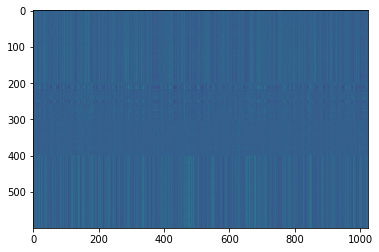

,AUC,pAUC
Source_0,0.699100,0.630000
Source_1,0.757900,0.667368
Source_2,0.844400,0.727895
Target_0,0.613100,0.640000
Target_1,0.773600,0.684737
Target_2,0.602000,0.505789
mean,0.715017,0.642632
h_mean,0.704311,0.634278


2021-06-01 21:50:00,472 - pytorch_modeler.py - INFO - epoch:51/300, train_losses:34.485682, val_AUC_hmean:0.704311, val_pAUC_hmean:0.634278, best_flag:True
2021-06-01 21:50:00,473 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 76.01it/s]
2021-06-01 21:50:00,632 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 112.85it/s]
2021-06-01 21:50:00,669 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 139.97it/s]
2021-06-01 21:50:00,707 - pytorch_modeler.py - INFO - epoch:52/300, train_losses:34.235764, val_AUC_hmean:0.696327, val_pAUC_hmean:0.622605, best_flag:False
2021-06-01 21:50:00,708 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 73.74it/s]
2021-06-01 21:50:00,873 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 108.15it/s]
2021-06-01 21:50:00,916 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 143.56it/s]
2021-06-01 21:5

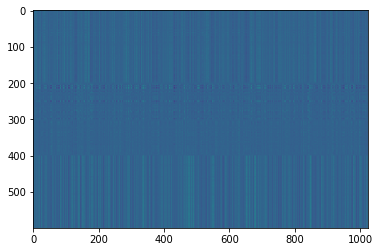

,AUC,pAUC
Source_0,0.707900,0.634211
Source_1,0.754100,0.636842
Source_2,0.854900,0.720526
Target_0,0.615900,0.638947
Target_1,0.792500,0.703158
Target_2,0.663600,0.519474
mean,0.731483,0.642193
h_mean,0.722818,0.635113


2021-06-01 21:50:05,277 - pytorch_modeler.py - INFO - epoch:65/300, train_losses:30.912284, val_AUC_hmean:0.722818, val_pAUC_hmean:0.635113, best_flag:True
2021-06-01 21:50:05,278 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 74.61it/s]
2021-06-01 21:50:05,441 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 121.28it/s]
2021-06-01 21:50:05,479 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 139.59it/s]
2021-06-01 21:50:05,517 - pytorch_modeler.py - INFO - epoch:66/300, train_losses:30.699514, val_AUC_hmean:0.713076, val_pAUC_hmean:0.626881, best_flag:False
2021-06-01 21:50:05,518 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 75.09it/s]
2021-06-01 21:50:05,680 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 109.28it/s]
2021-06-01 21:50:05,718 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 136.36it/s]
2021-06-01 21:5

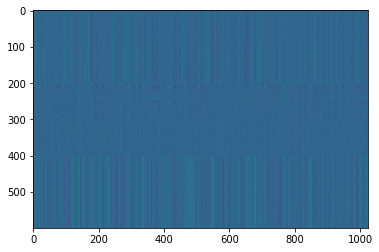

,AUC,pAUC
Source_0,0.734400,0.650000
Source_1,0.741100,0.637895
Source_2,0.862100,0.733158
Target_0,0.636900,0.643158
Target_1,0.769700,0.664737
Target_2,0.685000,0.526842
mean,0.738200,0.642632
h_mean,0.731696,0.636445


2021-06-01 21:50:10,507 - pytorch_modeler.py - INFO - epoch:80/300, train_losses:27.700296, val_AUC_hmean:0.731696, val_pAUC_hmean:0.636445, best_flag:True
2021-06-01 21:50:10,508 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 71.10it/s]
2021-06-01 21:50:10,679 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 133.88it/s]
2021-06-01 21:50:10,717 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 140.04it/s]
2021-06-01 21:50:10,754 - pytorch_modeler.py - INFO - epoch:81/300, train_losses:27.427049, val_AUC_hmean:0.709837, val_pAUC_hmean:0.630010, best_flag:False
2021-06-01 21:50:10,755 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 72.85it/s]
2021-06-01 21:50:10,921 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 131.30it/s]
2021-06-01 21:50:10,958 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 163.20it/s]
2021-06-01 21:5

100%|██████████| 2/2 [00:00<00:00, 133.23it/s]
2021-06-01 21:50:14,623 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 98.76it/s]
2021-06-01 21:50:14,669 - pytorch_modeler.py - INFO - epoch:97/300, train_losses:24.165015, val_AUC_hmean:0.714279, val_pAUC_hmean:0.630767, best_flag:False
2021-06-01 21:50:14,670 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 73.86it/s]
2021-06-01 21:50:14,834 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 133.97it/s]
2021-06-01 21:50:14,870 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 141.49it/s]
2021-06-01 21:50:14,910 - pytorch_modeler.py - INFO - epoch:98/300, train_losses:23.961410, val_AUC_hmean:0.717101, val_pAUC_hmean:0.631606, best_flag:False
2021-06-01 21:50:14,910 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 75.02it/s]
2021-06-01 21:50:15,072 - pytorch_modeler.py - INFO - valid_source
100%|██████████

2021-06-01 21:50:18,714 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 74.73it/s]
2021-06-01 21:50:18,876 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 135.95it/s]
2021-06-01 21:50:18,913 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 145.34it/s]
2021-06-01 21:50:18,951 - pytorch_modeler.py - INFO - epoch:114/300, train_losses:20.973040, val_AUC_hmean:0.721656, val_pAUC_hmean:0.632482, best_flag:False
2021-06-01 21:50:18,952 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 74.28it/s]
2021-06-01 21:50:19,115 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 97.96it/s]
2021-06-01 21:50:19,155 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 149.76it/s]
2021-06-01 21:50:19,192 - pytorch_modeler.py - INFO - epoch:115/300, train_losses:20.813987, val_AUC_hmean:0.723707, val_pAUC_hmean:0.629502, best_flag:False
2021-06-01 21

100%|██████████| 2/2 [00:00<00:00, 121.76it/s]
2021-06-01 21:50:22,949 - pytorch_modeler.py - INFO - epoch:130/300, train_losses:18.473462, val_AUC_hmean:0.699503, val_pAUC_hmean:0.624632, best_flag:False
2021-06-01 21:50:22,950 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 76.00it/s]
2021-06-01 21:50:23,110 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 129.46it/s]
2021-06-01 21:50:23,145 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 134.92it/s]
2021-06-01 21:50:23,182 - pytorch_modeler.py - INFO - epoch:131/300, train_losses:18.237179, val_AUC_hmean:0.717681, val_pAUC_hmean:0.626229, best_flag:False
2021-06-01 21:50:23,183 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 69.92it/s]
2021-06-01 21:50:23,357 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 124.67it/s]
2021-06-01 21:50:23,393 - pytorch_modeler.py - INFO - valid_target
100%|███████

100%|██████████| 12/12 [00:00<00:00, 66.03it/s]
2021-06-01 21:50:27,418 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 126.45it/s]
2021-06-01 21:50:27,453 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 140.53it/s]
2021-06-01 21:50:27,492 - pytorch_modeler.py - INFO - epoch:147/300, train_losses:16.032153, val_AUC_hmean:0.724854, val_pAUC_hmean:0.625993, best_flag:False
2021-06-01 21:50:27,493 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 68.08it/s]
2021-06-01 21:50:27,671 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 106.30it/s]
2021-06-01 21:50:27,713 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 118.61it/s]
2021-06-01 21:50:27,756 - pytorch_modeler.py - INFO - epoch:148/300, train_losses:15.773883, val_AUC_hmean:0.725462, val_pAUC_hmean:0.630033, best_flag:False
2021-06-01 21:50:27,757 - pytorch_modeler.py - INFO - train
100%|███████

In [ ]:
run(machine_types[2])